In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    GlobalAveragePooling1D, BatchNormalization, LeakyReLU, Dropout, GlobalMaxPooling1D, ReLU

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_data = pd.read_csv('../Dataset/train.csv', engine='python', encoding='utf-8')
train_data

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
...,...,...,...,...,...,...
44995,60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,2020-02-29 02:22:18,LQ_CLOSE
44996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE
44997,60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,2020-02-29 04:34:16,LQ_CLOSE
44998,60465318,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,2020-02-29 12:50:43,LQ_CLOSE


In [4]:
valid_data = pd.read_csv('../Dataset/valid.csv', engine='python', encoding='utf-8')
valid_data

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT
...,...,...,...,...,...,...
14995,60465681,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,2020-02-29 13:32:56,LQ_CLOSE
14996,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,2020-02-29 17:46:41,LQ_CLOSE
14997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,2020-02-29 18:35:39,LQ_EDIT
14998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,2020-02-29 20:32:14,LQ_CLOSE


In [12]:
data = pd.concat([train_data, valid_data])
data = data.drop(columns = ['Id', 'CreationDate'])
data

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ
...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,LQ_CLOSE
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,LQ_CLOSE
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,LQ_EDIT
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,LQ_CLOSE


In [13]:
data['label'] = data['Y'].map({'HQ' : 0, 'LQ_EDIT' : 1, 'LQ_CLOSE' : 2})
data

,Title,Body,Tags,Y,label
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE,2
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ,0
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ,0
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ,0
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ,0
...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,LQ_CLOSE,2
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,LQ_CLOSE,2
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,LQ_EDIT,1
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,LQ_CLOSE,2


In [14]:
def clean_text_tags(text):
    text = re.sub("<|>", " ", text)
    return text

In [15]:
data['Tags'] = data['Tags'].progress_apply(clean_text_tags)
data

  0%|          | 0/60000 [00:00<?, ?it/s]

,Title,Body,Tags,Y,label
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0
...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",html css flexbox,LQ_CLOSE,2
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,c++,LQ_CLOSE,2
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,django django-views django-templates,LQ_EDIT,1
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,javascript php html,LQ_CLOSE,2


In [16]:
data['combined_text'] = data['Title'] + ' ' + data['Body'] + ' ' + data['Tags']
# data['Combined_text'] = data['Body']
data

,Title,Body,Tags,Y,label,combined_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2,Java: Repeat Task Every Random Seconds <p>I'm ...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0,Why are Java Optionals immutable? <p>I'd like ...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0,Text Overlay Image with Darkened Opacity React...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0,Why ternary operator in swift is so picky? <p>...
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0,hide/show fab with scale animation <p>I'm usin...
...,...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",html css flexbox,LQ_CLOSE,2,How can I align two flex boxes to follow each ...
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,c++,LQ_CLOSE,2,C++ The correct way to multiply an integer and...
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,django django-views django-templates,LQ_EDIT,1,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,javascript php html,LQ_CLOSE,2,PHP - getting the content of php page <p>I hav...


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          60000 non-null  object
 1   Body           60000 non-null  object
 2   Tags           60000 non-null  object
 3   Y              60000 non-null  object
 4   label          60000 non-null  int64 
 5   Combined_text  60000 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.2+ MB


[Text(0, 0, '20000'), Text(0, 0, '20000'), Text(0, 0, '20000')]

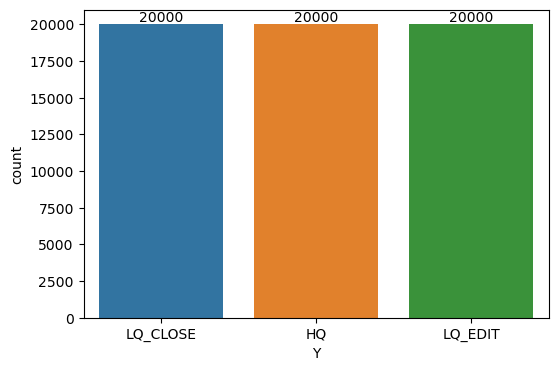

In [10]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Y')
ax.bar_label(ax.containers[0])

In [17]:
# CLEANR = re.compile('<.*?>') 
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def clean_text(text):
    text = text.lower()
    text = text.replace("[^a-zA-Z#]", " ")
    text = text.replace('http\S+|www.\S+|.com\S+', ' ')
    text = re.sub(CLEANR, ' ', text)
    text = re.sub("#+"," ", text)
    text = re.sub("@[\w]*"," ", text)
    text = re.sub("[^a-z\s]"," ", text)
    text = re.sub("@[A-Za-z0-9_]+"," ", text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [30]:
# temp = data[data['clean_text'].str.contains('\r')]
# temp

In [18]:
data['clean_text'] = data['combined_text'] \
                    .progress_apply(clean_text) \
                    .progress_apply(remove_duplicate_words) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4])) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (stopword_list)]))

data

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

,Title,Body,Tags,Y,label,combined_text,clean_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2,Java: Repeat Task Every Random Seconds <p>I'm ...,java repeat task random familiar repeating tas...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0,Why are Java Optionals immutable? <p>I'd like ...,java optionals immutable understand java optio...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0,Text Overlay Image with Darkened Opacity React...,overlay image darkened opacity react native at...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0,Why ternary operator in swift is so picky? <p>...,ternary operator swift picky question simple a...
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0,hide/show fab with scale animation <p>I'm usin...,hide scale animation custom floatingactionmenu...
...,...,...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",html css flexbox,LQ_CLOSE,2,How can I align two flex boxes to follow each ...,align flex boxes follow menu controls theory l...
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,c++,LQ_CLOSE,2,C++ The correct way to multiply an integer and...,correct multiply integer double multiply integ...
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,django django-views django-templates,LQ_EDIT,1,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,django error hyperlink urls urls file django c...
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,javascript php html,LQ_CLOSE,2,PHP - getting the content of php page <p>I hav...,content controller server connected network se...


In [12]:
# np.savetxt(r'clean_text.csv', data['clean_text'].values, fmt='%s')

<Axes: xlabel='text_len'>

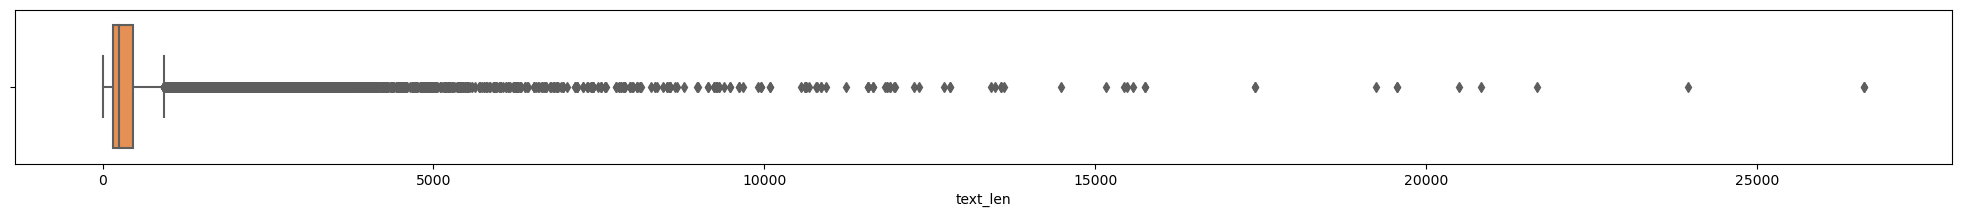

In [19]:
text_len = []

for idx, teks in enumerate(data['clean_text']):
    text_len.append(len(teks))
data['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

In [26]:
print(data['text_len'].quantile(0.001))
print(data['text_len'].quantile(0.75))

31.0
466.25


31.0
466.25


<Axes: xlabel='text_len'>

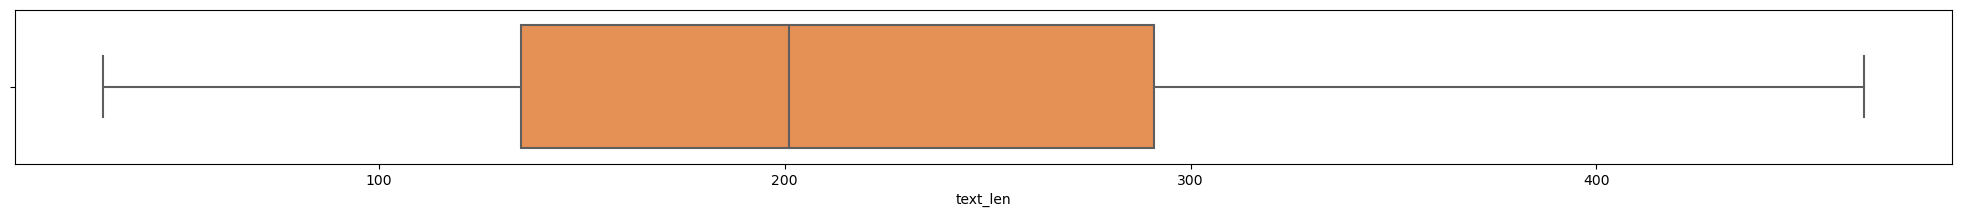

In [27]:
Q1 = data['text_len'].quantile(0.001)
Q3 = data['text_len'].quantile(0.75)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

[Text(0, 0, '16335'), Text(0, 0, '13381'), Text(0, 0, '15220')]

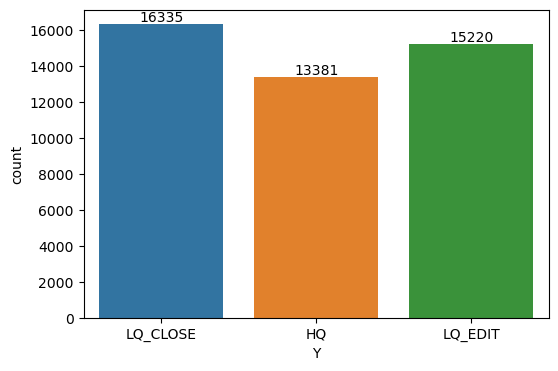

In [28]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Y')
ax.bar_label(ax.containers[0])

In [29]:
X = data['clean_text']
Y = to_categorical(data['label'])

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(31544,)
(8898,)
(4494,)


In [30]:
vocab_size = 10000
embedding_dim = 64
max_length = 467
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [31]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print(len(word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

80295


In [46]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GlobalAveragePooling1D())

    model.add(Dense(64, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(32, kernel_regularizer=keras.regularizers.l2(l=0.1)))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    # model.add(Dense(1, activation='sigmoid'))
    return model

def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same', kernel_initializer='he_normal'))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # model.add(Conv1D(512, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same', kernel_initializer='he_normal'))
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(MaxPooling1D())
    # model.add(Dropout(0.4))
    # model.add(BatchNormalization())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same', kernel_initializer='he_normal'))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same', kernel_initializer='he_normal'))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(GRU(units=32))
    model.add(Dense(units=1))
    return model

def CuDNNGRU_Model():
    sequences = layers.Input(shape=(max_length,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    return model
    


# model = DNN_Model()
model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()
# model = CuDNNGRU_Model()
# model = RNN_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
opt = Adam(learning_rate = 0.001)

# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
# model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 467, 64)           640000    
                                                                 
 conv1d_6 (Conv1D)           (None, 467, 64)           12352     
                                                                 
 re_lu_6 (ReLU)              (None, 467, 64)           0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 233, 64)          0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 233, 64)           0         
                                                                 
 batch_normalization_6 (Batc  (None, 233, 64)          256       
 hNormalization)                                      

In [47]:
num_epoch = 20
batch_size = 64

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (testing_padded, testing_label))

Epoch 1/20
493/493 [==============================] - 10s 17ms/step - loss: 1.2900 - accuracy: 0.5019 - val_loss: 1.9498 - val_accuracy: 0.3753
Epoch 2/20
493/493 [==============================] - 8s 17ms/step - loss: 0.9798 - accuracy: 0.6340 - val_loss: 1.5682 - val_accuracy: 0.5080
Epoch 3/20
493/493 [==============================] - 8s 17ms/step - loss: 0.8277 - accuracy: 0.6802 - val_loss: 1.1796 - val_accuracy: 0.5866
Epoch 4/20
493/493 [==============================] - 8s 16ms/step - loss: 0.7291 - accuracy: 0.7201 - val_loss: 0.9910 - val_accuracy: 0.6136
Epoch 5/20
493/493 [==============================] - 8s 16ms/step - loss: 0.6556 - accuracy: 0.7480 - val_loss: 1.0054 - val_accuracy: 0.6208
Epoch 6/20
493/493 [==============================] - 8s 16ms/step - loss: 0.5935 - accuracy: 0.7736 - val_loss: 1.0278 - val_accuracy: 0.6199
Epoch 7/20
493/493 [==============================] - 8s 17ms/step - loss: 0.5379 - accuracy: 0.8033 - val_loss: 1.0417 - val_accuracy: 0.627

In [44]:
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
# initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
# initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
# initializer = tf.keras.initializers.Zeros()
# initializer = tf.keras.initializers.Ones()
# initializer = tf.keras.initializers.GlorotNormal()
# initializer = tf.keras.initializers.GlorotUniform()
# initializer = tf.keras.initializers.HeNormal()
# initializer = tf.keras.initializers.HeUniform()
# initializer = tf.keras.initializers.Identity()
# initializer = tf.keras.initializers.Orthogonal()
# initializer = tf.keras.initializers.Constant(3.)
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

values = initializer(shape=(2, 2))
values

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.00587887, -0.2507034 ],
       [-0.11425212,  0.13497096]], dtype=float32)>

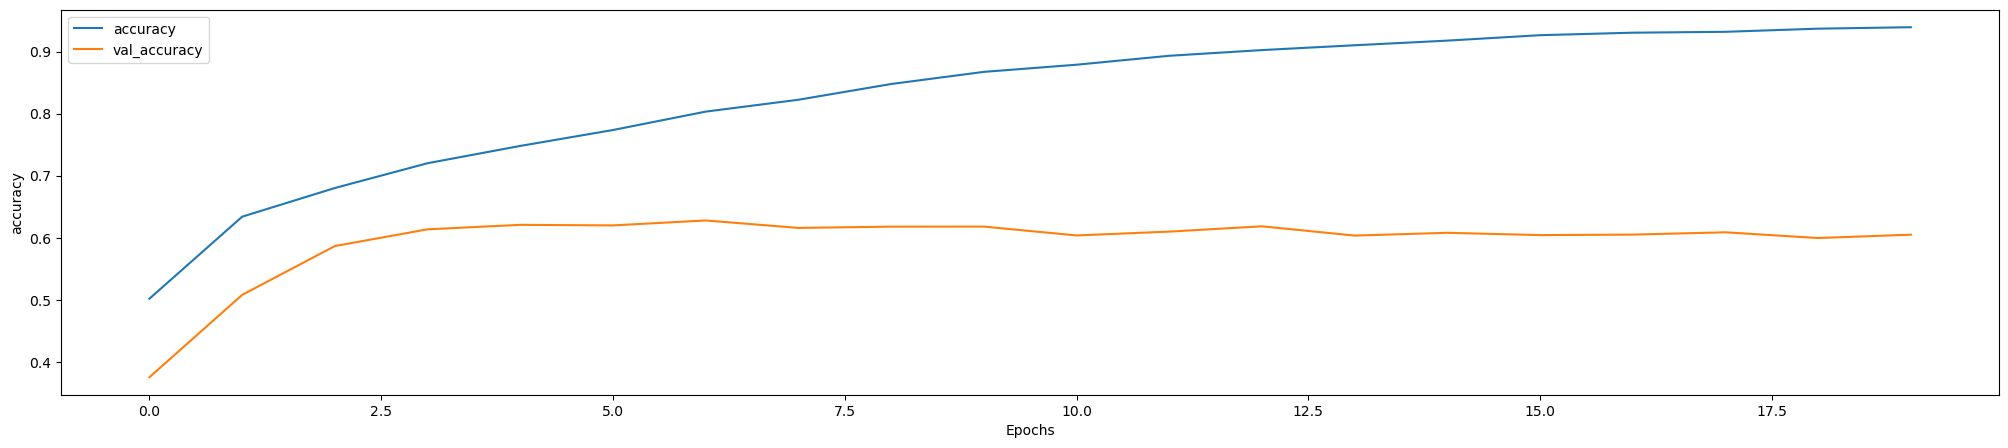

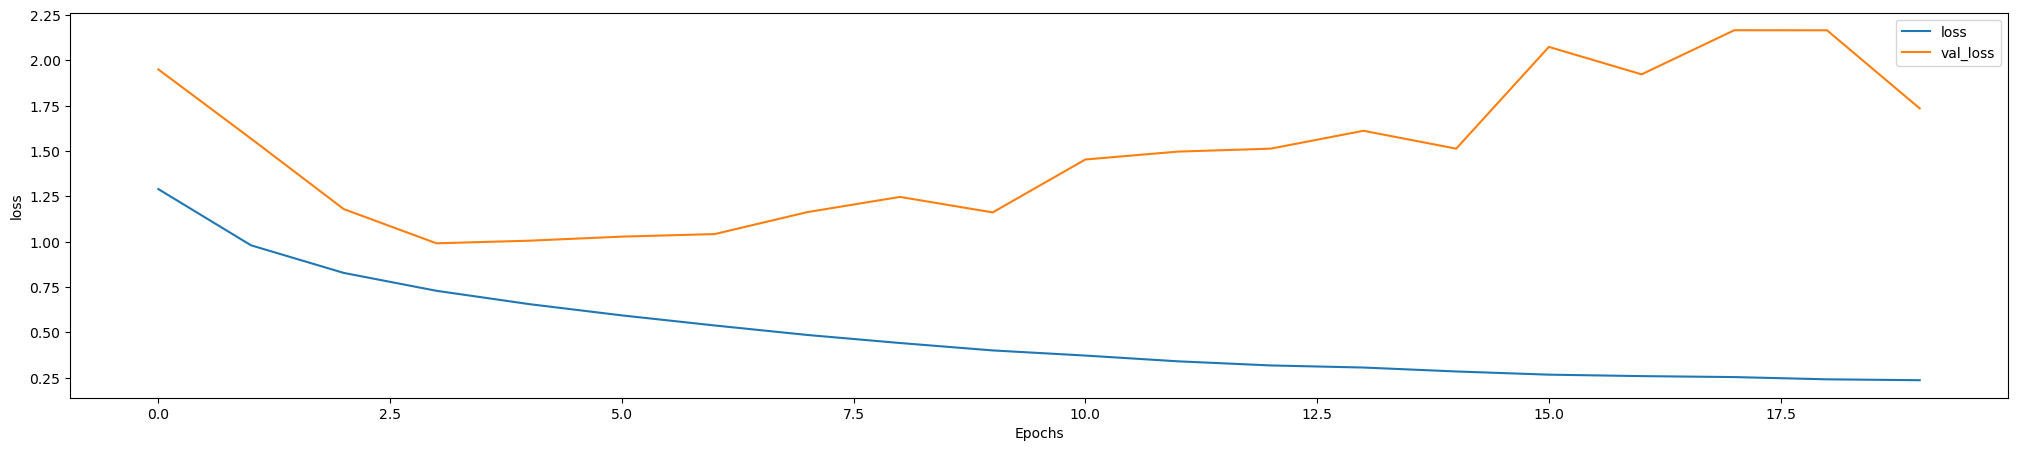

In [48]:
def plot_graphs(history, string):
    plt.subplots(figsize=(25, 5))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

94/94 [==============================] - 1s 9ms/step


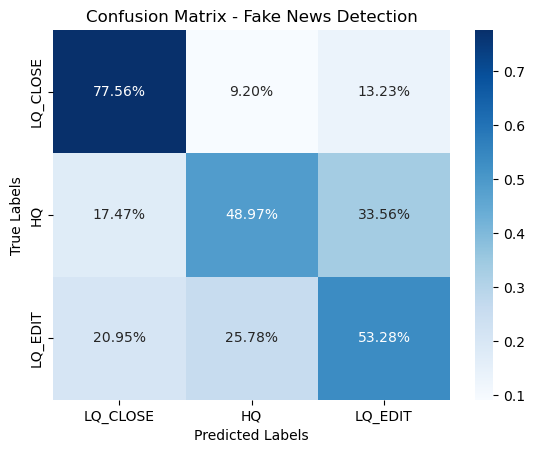

In [24]:
labels = ['LQ_CLOSE', 'HQ', 'LQ_EDIT']

y_pred = np.rint(model.predict(validating_padded))
# Build confusion matrix
con_mat = confusion_matrix(validating_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [78]:
# mlp for the blobs multi-class classification problem with cross-entropy loss
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
# y = to_categorical(y)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/100


ValueError: in user code:

    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [79]:
y

array([2, 2, 2, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 0, 0, 1, 2, 2, 1, 1, 2, 0,
       0, 2, 1, 1, 2, 2, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1, 2, 0, 2, 1, 1, 2,
       1, 0, 0, 1, 1, 0, 0, 2, 0, 2, 2, 2, 2, 0, 1, 1, 2, 0, 2, 0, 0, 1,
       0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2,
       1, 1, 2, 0, 2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 2,
       0, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2, 0, 2, 0,
       0, 0, 1, 0, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0, 0, 1, 2, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, 2,
       1, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 0, 0, 0, 2, 1, 1, 1, 0, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 0, 1, 2, 2, 0, 2, 0, 1, 0, 1,
       1, 2, 2, 0, 2, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 1,
       2, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2,
       2, 0, 1, 0, 2, 1, 1, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0,
       1, 0, 2, 2, 2, 1, 2, 0, 1, 1, 1, 0, 2, 0, 1,